# 1D projections for HAWC and IceCube

#### Import Statements

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import healpy as hp
import os
import astropy
import scipy
from scipy.optimize import curve_fit
import math
import glob as gb
import sys
sys.path.append('/data/user/fawolf')
from smooth import smooth, smooth_significance

#### IceCube files from the server

In [72]:
#IceCube data files
directory_path = '/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged'
pattern = 'IC86_24H_sid_*.fits'
IceCube_file_path = gb.glob(directory_path + "/" + pattern)
IceCube_file_path = sorted(IceCube_file_path)

for file_path in IceCube_file_path:
    print(file_path)

/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4-4.25GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.25-4.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.5-4.75GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.75-5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5-5.25GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5.25-5.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_5.5-6GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_6-6.5GeV.fits
/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_6.5-100GeV.fits


#### HAWC files from the server

In [73]:
#HAWC bins
bin_names = sorted(os.listdir('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco'))
print(bin_names)

['bin0', 'bin1', 'bin2', 'bin3']


#### Curve fit function

In [74]:
#this is the function for the dipole + quadropole + octopole
def func(x, A1, phi1, A2, phi2, A3, phi3):
    return (A1 * np.cos(x + phi1)) + (A2 * np.cos(2*x + phi2)) + (A3 * np.cos(3*x + phi3))

#### Error band for curve fit

In [75]:
def fit_err_band(x, ri_fit, ri_cov, func):
    ymax = -np.ones(len(x))*np.inf
    ymin = np.ones(len(x))*np.inf
    errs = np.sqrt(np.diag(ri_cov))
    for i in range(-1,2):
        for j in range(-1,2):
            for k in range(-1,2):
                for l in range(-1,2):
                    for m in range(-1,2):
                        for n in range(-1,2):
                            pvals = np.array(ri_fit) + np.array(errs)*np.array([i,j,k,l,m,n]) 
                            ymin = np.minimum(ymin, func(x,*pvals)) 
                            ymax = np.maximum(ymax, func(x,*pvals)) 
                            
    return ymin, ymax

#### Correction function

In [76]:
polynomial_coeff =  [-4.69087062e-04, -2.25275535e-03, -4.40691390e-03, -4.53214075e-03, -2.17028919e-03, -6.84256681e-05]
cosine_fit =  [ 0.00036938, -0.02608274]

polynomial = np.poly1d(polynomial_coeff)

def cosine_function(x,A,phi):
    return A*np.cos(x+phi)

def correction(dec):
    expected = cosine_function(np.radians(dec),*cosine_fit)
    observed = polynomial(np.radians(dec))
    return expected/observed

#### Plot 1D with errors function to plot the relative intensity vs right ascension

In [77]:
#value of alpha needs to be 20 for IceCube and 1 for HAWC
def plot_1d_w_errors(data, background, relative_intensity, title = '',
                     top = 70, bottom = -20, bins = 24, alpha = 20, show_plot = True, observatory = True):
    npix = len(data)
    nside = hp.npix2nside(npix)  #you can also calculate nside using int(math.sqrt(npix/12))
    
    #defining ranges
    min_pix = hp.ang2pix(nside, 0, top, lonlat=True)
    max_pix = hp.ang2pix(nside, 0, bottom, lonlat=True)
    umpix = range(min_pix, max_pix)
    
    #healpy UNSEEN to mask the values not needed
    relative_intensity[:min_pix] = hp.UNSEEN
    relative_intensity[max_pix:] = hp.UNSEEN
    
    #declaring and initializing the variables that will be used
    az_bins = np.linspace(np.pi/24, 2*np.pi, bins) #creating an array for right ascension
    bin_vals = np.zeros(bins) #relative intensity
    bin_counts = np.zeros(bins)
    bin_data = np.zeros(bins) #data
    bin_bg = np.zeros(bins) #background
    zen, az = hp.pix2ang(nside,range(npix)) #zenith and azimuthal angle
    ra, dec = hp.pix2ang(nside,range(npix), lonlat = True) #right ascension and declination
    
    for pix in umpix:
        
        ibin = np.digitize(az[pix], az_bins)
        
        #if observatory = True, then its IceCube
        if observatory == True:
            bin_vals[ibin]+=relative_intensity[pix] * correction(dec[pix])  #relative intensity
            
        #if observatory = False, then its HAWC
        elif observatory == False:
            bin_vals[ibin]+=relative_intensity[pix] #relative intensity
            
        bin_counts[ibin]+= 1 #1
        bin_data[ibin] += data[pix] #data
        bin_bg[ibin] += background[pix] #background
        
    yerr2 = np.power(bin_data/bin_bg,2)*(1/bin_data+1/bin_bg/alpha) #y error squared
    
    if show_plot:
        
        ri_fit, ri_cov = curve_fit(func, az_bins, bin_vals/bin_counts)
        
        #plots the points of relative intensity with respect to right ascension
        if observatory == True:
            plt.errorbar(np.degrees(az_bins),bin_vals/bin_counts*1e4,yerr=np.sqrt(yerr2)*1e4,fmt='.', color = 'royalblue')

        elif observatory == False:
            plt.errorbar(np.degrees(az_bins),bin_vals/bin_counts*1e4,yerr=np.sqrt(yerr2)*1e4,fmt='.', color = 'orange')
        
        #plots the curve fit line
        if observatory == True:
            plt.errorbar(np.degrees(az_bins) , func(az_bins, *ri_fit)*1e4, label = 'IceCube', color = 'royalblue')

        elif observatory == False:
            plt.errorbar(np.degrees(az_bins) , func(az_bins, *ri_fit)*1e4, label = 'HAWC', color = 'orange')
        
        y_min, y_max = fit_err_band(np.linspace(0,2*np.pi, 100), ri_fit,ri_cov, func)
        
        #plots the error band
        if observatory == True:
            plt.fill_between(np.degrees(np.linspace(0,2*np.pi, 100)), y_min*1e4, y_max*1e4, alpha = 0.3, color = 'blue') #alpha is the transparancy

        elif observatory == False:
            plt.fill_between(np.degrees(np.linspace(0,2*np.pi, 100)), y_min*1e4, y_max*1e4, alpha = 0.3, color = 'orange') #alpha is the transparancy
        
        plt.title("1-D projection of adjacent declination bins")
        plt.xlabel("RA (°)")
        plt.ylabel("Relative Intensity[10^-3]")
        
        
    return yerr2, bin_vals

#### Plotting IceCube Graphs

IC86_24H_sid_4-4.25GeV.fits


/tmp/ipykernel_885/3067142811.py:7: RuntimeWarning: invalid value encountered in divide
  relative_intensity = (np.nan_to_num(data_column / background_column) - 1)


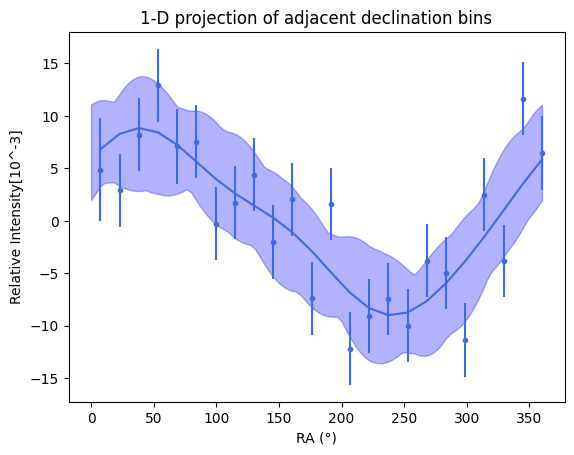


IC86_24H_sid_4.25-4.5GeV.fits


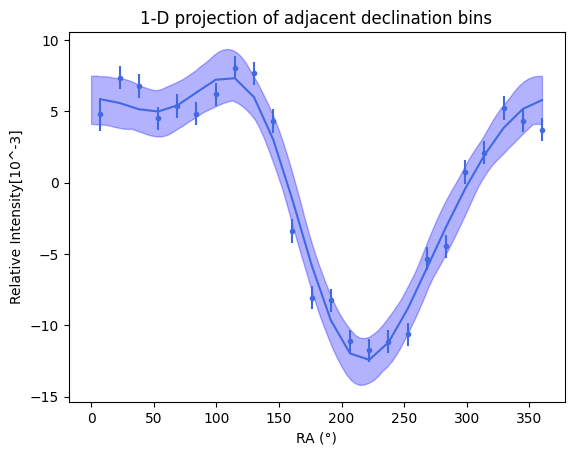


IC86_24H_sid_4.5-4.75GeV.fits


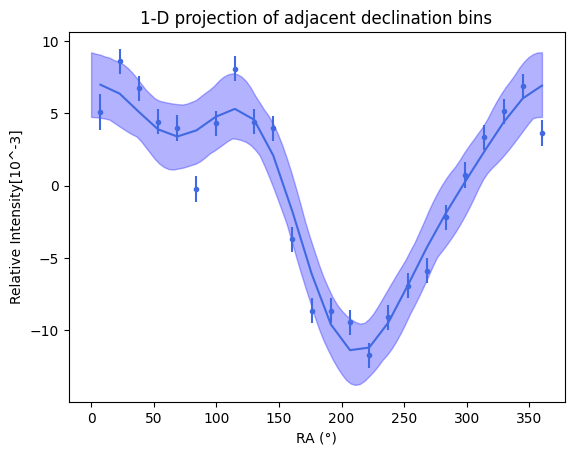


IC86_24H_sid_4.75-5GeV.fits


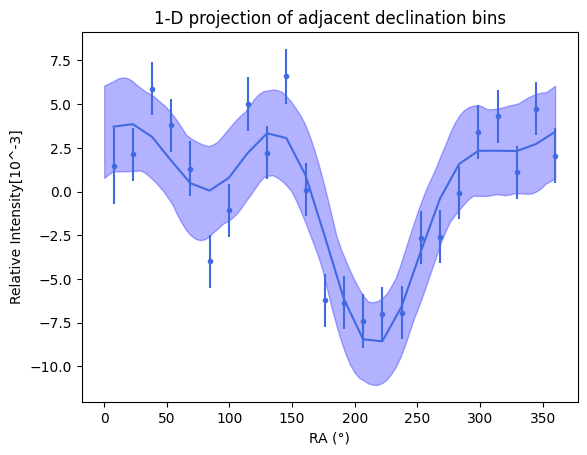


IC86_24H_sid_5-5.25GeV.fits


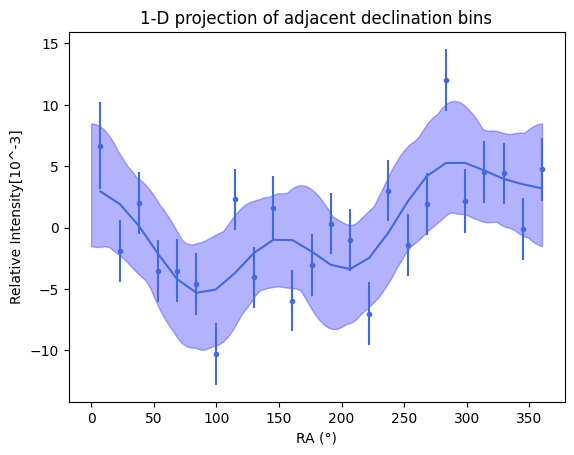


IC86_24H_sid_5.25-5.5GeV.fits


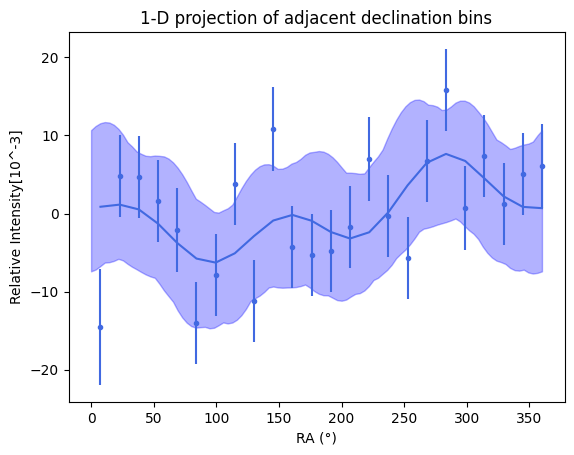


IC86_24H_sid_5.5-6GeV.fits


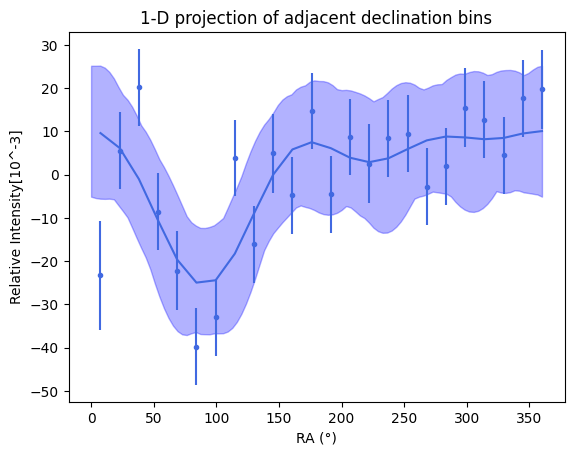


IC86_24H_sid_6-6.5GeV.fits


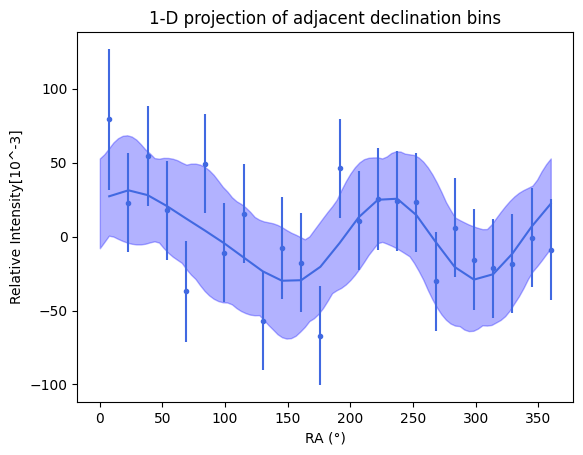


IC86_24H_sid_6.5-100GeV.fits


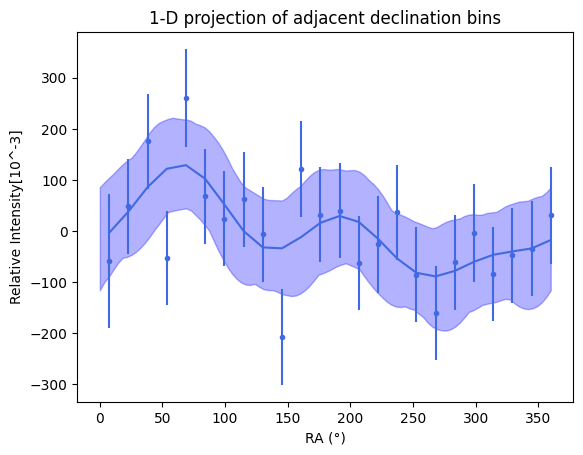

In [78]:
relative_intensity = []

for file_path in IceCube_file_path:
    
    data_column = hp.read_map(file_path, field = 0)
    background_column = hp.read_map(file_path, field = 1)
    relative_intensity = (np.nan_to_num(data_column / background_column) - 1)

    print(os.path.basename(file_path))
    plot_1d_w_errors(data_column, background_column, relative_intensity, 
                     top = -21, bottom = -24, alpha = 20, show_plot = True, observatory = True)
    plt.show()
    print()

#### Plotting HAWC Graphs

Bin: bin0


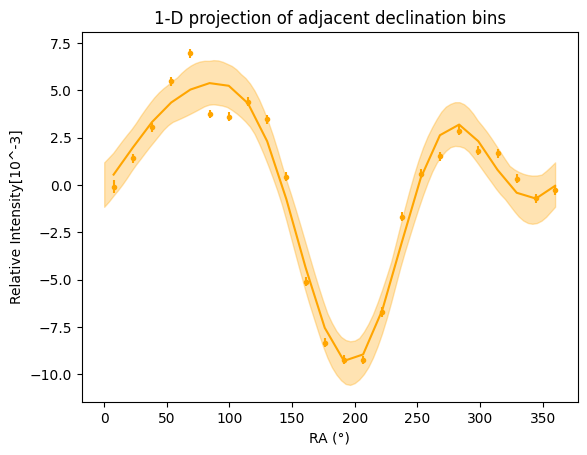

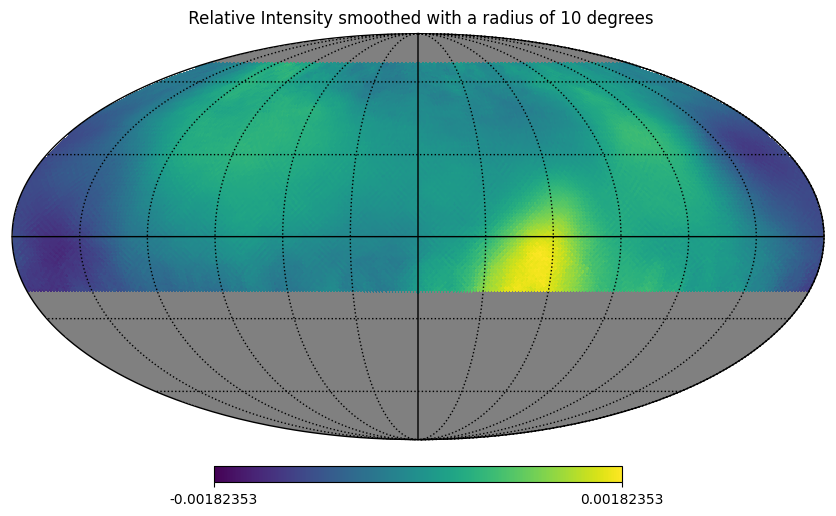

Bin: bin1


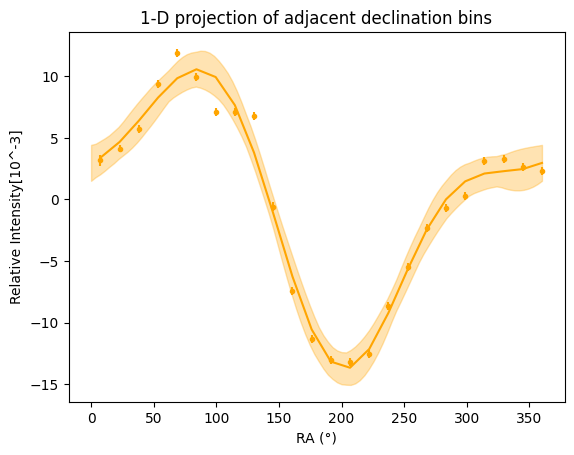

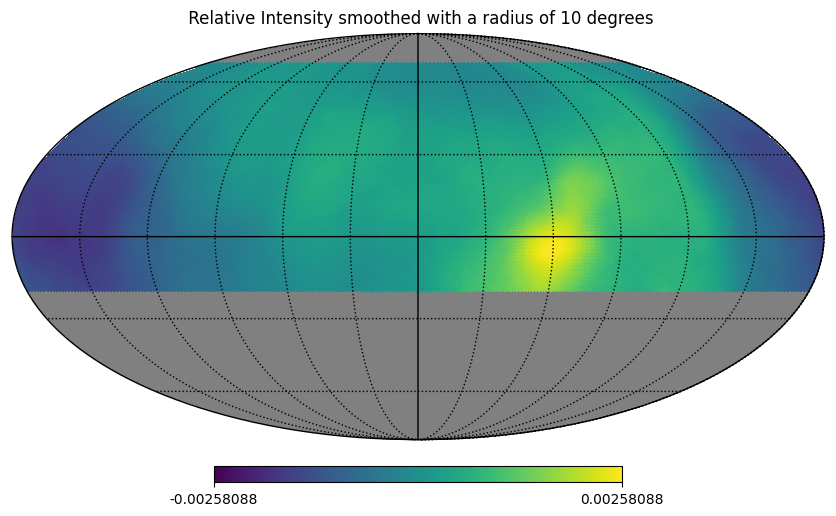

Bin: bin2


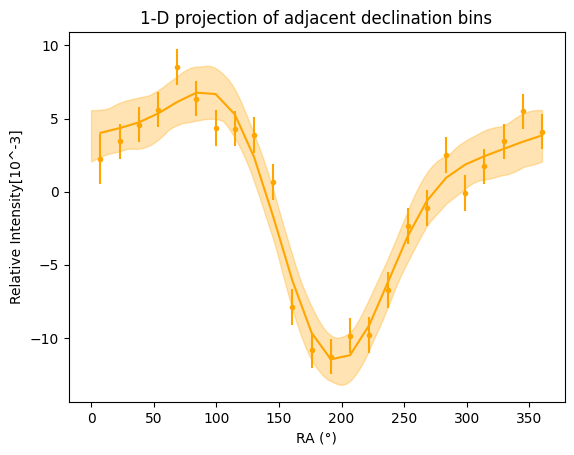

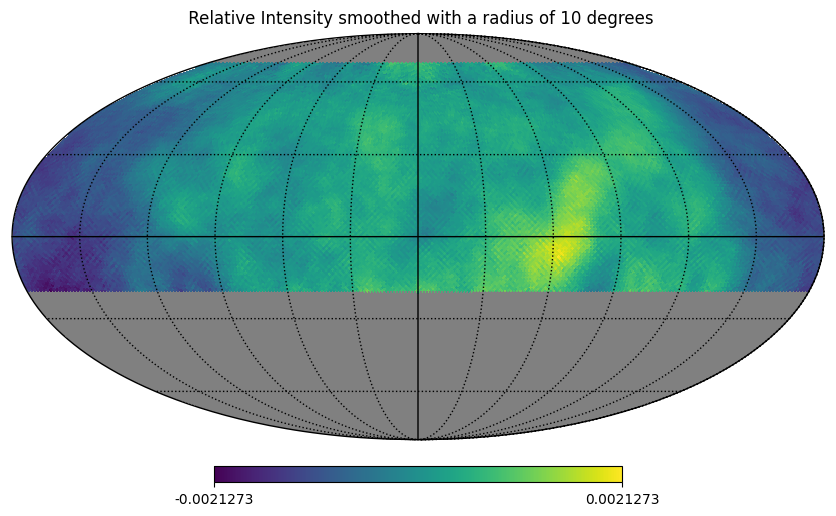

Bin: bin3


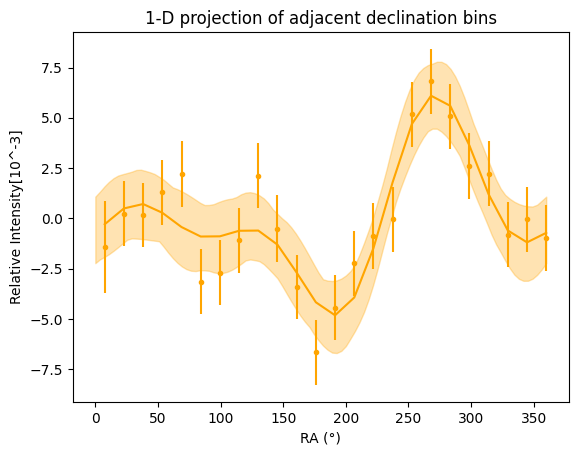

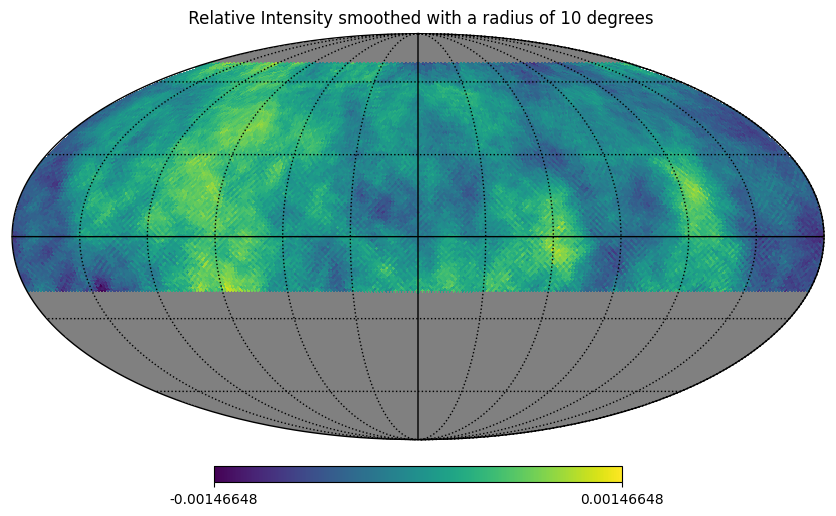

In [79]:
data_final = []
relative_int_final = []
background_final = []

for bin_name in bin_names:
    data_path = '/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/{0}/data_HAWC_64_360.fits'.format(bin_name)
    data = hp.read_map(data_path)
    data_final.append(data)
    
    relative_intensity_path = '/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/{0}/CR_HAWC_64_360_iteration20.fits'.format(bin_name)
    relative_intensity = hp.read_map(relative_intensity_path)
    relative_int_final.append(relative_intensity)
    
    #relative_intensity = (data/background) - 1
    background = data / (relative_intensity + 1)
    background_final.append(background)
    
    print("Bin: " + bin_name)
    plot_1d_w_errors(data, background, relative_intensity, top = 70, bottom = -20, alpha = 1, show_plot = True, observatory = False)
    smoothed_intensity = smooth(relative_intensity_path, radius = 10, cutoff = True)
    plt.show()

#### Chi squared test fucntion

In [80]:
# Using the chi^2 distribution to check if the graphs are compatible or not
def chi_squared(relative_int_1, relative_int_2, yerr1, yerr2):
    
    delta = relative_int_1 - relative_int_2  # Calculate the difference between the two datasets' y-values
    chi_sq_values = np.power(delta, 2) / (yerr1 + yerr2) # Calculate the squared differences divided by the sum of the squared errors
    chi_sq_total = np.sum(chi_sq_values)  # Sum up all the chi-squared values to get the chi-squared statistic

    # Calculate the reduced chi-squared statistic by dividing by the degrees of freedom
    degrees_of_freedom = len(relative_int_1) - 1  # This is 23 if you have 24 bins
    chi_squared_reduced = chi_sq_total / degrees_of_freedom
    
    return chi_squared_reduced

#### IceCube files for combined graph

In [81]:
IceCube_usage_file_path = []
IceCube_usage_file_path.append(IceCube_file_path[0])
IceCube_usage_file_path.append(IceCube_file_path[2])
IceCube_usage_file_path.append(IceCube_file_path[3])
print(IceCube_usage_file_path[1])

/data/ana/CosmicRay/Anisotropy/IceCube/twelve_year/maps/merged/IC86_24H_sid_4.5-4.75GeV.fits


#### Combined Graph - 1

/tmp/ipykernel_885/237880039.py:6: RuntimeWarning: invalid value encountered in divide
  rel_int1_iceCube = (np.nan_to_num(data1_iceCube / background1_iceCube) - 1)


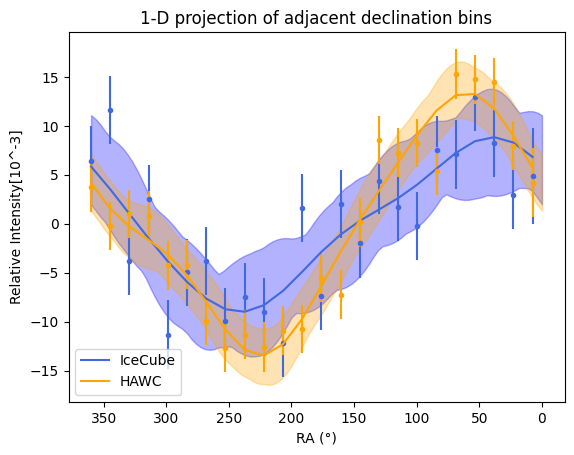

In [82]:
#Combining the 1st bin of IceCube with bin1 of HAWC

#IceCube
data1_iceCube = hp.read_map(IceCube_usage_file_path[0], field = 0)
background1_iceCube = hp.read_map(IceCube_usage_file_path[0], field = 1)
rel_int1_iceCube = (np.nan_to_num(data1_iceCube / background1_iceCube) - 1)
yerr_1_iceCube , bin_vals_1_iceCube = plot_1d_w_errors(data1_iceCube, background1_iceCube, rel_int1_iceCube, 
                 top = -21, bottom = -24, alpha = 20, show_plot = True, observatory = True)

#HAWC
data1_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin1/data_HAWC_64_360.fits')
rel_int1_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin1/CR_HAWC_64_360_iteration20.fits')
background1_hawc = data1_hawc / (rel_int1_hawc + 1)
yerr_1_hawc , bin_vals_1_hawc = plot_1d_w_errors(data1_hawc, background1_hawc, rel_int1_hawc, 
                 top = -21, bottom = -24, alpha = 1, show_plot = True, observatory = False)
plt.gca().invert_xaxis()
plt.legend(loc = 'lower left')
plt.show()

In [83]:
# chi squared test for the 1st combined graph
chi_squared_test_result_1 = chi_squared(bin_vals_1_iceCube , bin_vals_1_hawc , yerr_1_iceCube , yerr_1_hawc)
print(chi_squared_test_result_1)

3660.052258920151


#### Combined Graph - 2

/tmp/ipykernel_885/2910942625.py:6: RuntimeWarning: invalid value encountered in divide
  rel_int2_iceCube = (np.nan_to_num(data2_iceCube / background2_iceCube) - 1)


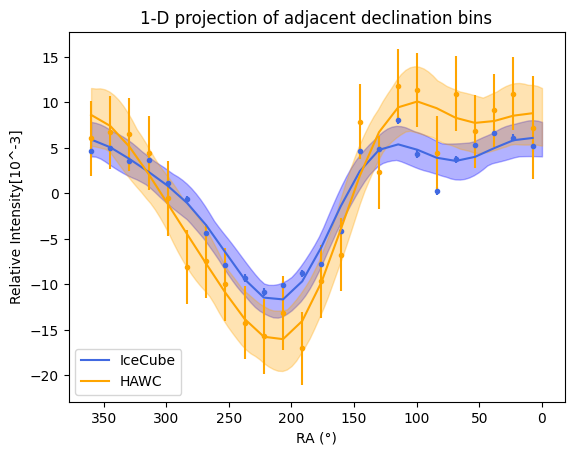

In [84]:
#Combining the 3st bin of IceCube with bin2 of HAWC

#IceCube
data2_iceCube = hp.read_map(IceCube_usage_file_path[1], field = 0)
background2_iceCube = hp.read_map(IceCube_usage_file_path[1], field = 1)
rel_int2_iceCube = (np.nan_to_num(data2_iceCube / background2_iceCube) - 1)
yerr_2_iceCube , bin_vals_2_iceCube = plot_1d_w_errors(data2_iceCube, background2_iceCube, rel_int2_iceCube, 
                 top = -18, bottom = -29, alpha = 20, show_plot = True, observatory = True)

#HAWC
data2_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin2/data_HAWC_64_360.fits')
rel_int2_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin2/CR_HAWC_64_360_iteration20.fits')
background2_hawc = data2_hawc / (rel_int2_hawc + 1)
yerr_2_hawc , bin_vals_2_hawc = plot_1d_w_errors(data2_hawc, background2_hawc, rel_int2_hawc, 
                 top = -18, bottom = -29, alpha = 1, show_plot = True, observatory = False)
plt.gca().invert_xaxis()
plt.legend(loc = 'lower left')
plt.show()

In [85]:
#chi squared test for the 2nd combined graph 
chi_squared_test_result_2 = chi_squared(bin_vals_2_iceCube , bin_vals_2_hawc , yerr_2_iceCube , yerr_2_hawc)
print(chi_squared_test_result_2)

40658.658083549926


#### Combined Graph - 3

/tmp/ipykernel_885/1556600070.py:7: RuntimeWarning: invalid value encountered in divide
  rel_int3_iceCube = (np.nan_to_num(data3_iceCube / background3_iceCube) - 1)


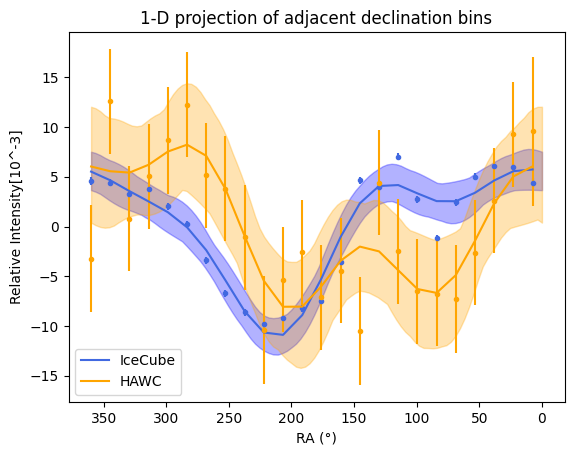

In [86]:
#Combining the (3rd + 4th) bin of IceCube with bin3 of HAWC

data3_iceCube = hp.read_map(IceCube_usage_file_path[2], field = 0)
background3_iceCube = hp.read_map(IceCube_usage_file_path[2], field = 1)
data3_iceCube = data3_iceCube + data2_iceCube
background3_iceCube = background3_iceCube + background2_iceCube
rel_int3_iceCube = (np.nan_to_num(data3_iceCube / background3_iceCube) - 1)
yerr_3_iceCube , bin_vals_3_iceCube = plot_1d_w_errors(data3_iceCube, background3_iceCube, rel_int3_iceCube, 
                 top = -17, bottom = -29, alpha = 20, show_plot = True, observatory = True)

data3_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin3/data_HAWC_64_360.fits')
rel_int3_hawc = hp.read_map('/data/user/juancarlos/anisotropy/HAWC/local/pass5/reco/bin3/CR_HAWC_64_360_iteration20.fits')
background3_hawc = data3_hawc / (rel_int3_hawc + 1)
yerr_3_hawc , bin_vals_3_hawc = plot_1d_w_errors(data3_hawc, background3_hawc, rel_int3_hawc, 
                 top = -17, bottom = -29, alpha = 1, show_plot = True, observatory = False)
plt.gca().invert_xaxis()
plt.legend(loc = 'lower left')
plt.show()

In [87]:
#chi squared test for the 3rd combined graph
chi_squared_test_result_3 = chi_squared(bin_vals_3_iceCube , bin_vals_3_hawc , yerr_3_iceCube , yerr_3_hawc)
print(chi_squared_test_result_3)

71398.2794428455


#### Combining all the plots into one plot

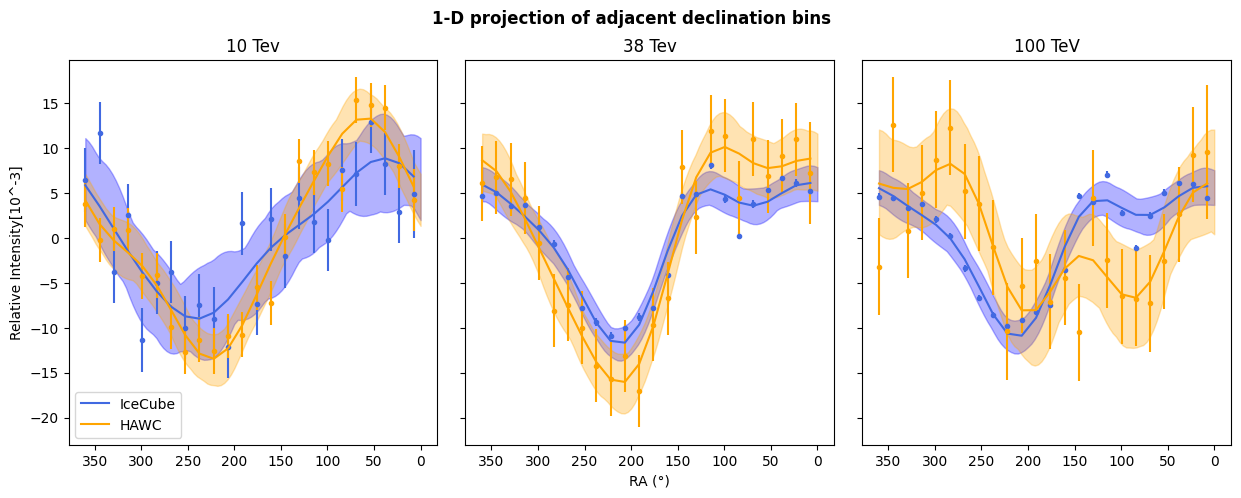

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.076})

# Plot for the 1st bin
plt.sca(axs[0])
plot_1d_w_errors(data1_iceCube, background1_iceCube, rel_int1_iceCube, 
                 top = -21, bottom = -24, alpha = 20, show_plot = True, observatory = True)
plot_1d_w_errors(data1_hawc, background1_hawc, rel_int1_hawc, 
                 top = -21, bottom = -24, alpha = 1, show_plot = True, observatory = False)
axs[0].set_xlabel("") # Empty string for x-label
axs[0].set_ylabel("Relative Intensity[10^-3]")
axs[0].set_title("10 Tev")
axs[0].legend(loc = 'lower left')
plt.gca().invert_xaxis()

# Plot for the 2nd bin
plt.sca(axs[1])
plot_1d_w_errors(data2_iceCube, background2_iceCube, rel_int2_iceCube, 
                 top = -18, bottom = -29, alpha = 20, show_plot = True, observatory = True)
plot_1d_w_errors(data2_hawc, background2_hawc, rel_int2_hawc, 
                 top = -18, bottom = -29, alpha = 1, show_plot = True, observatory = False)
axs[1].set_xlabel("RA (°)")
axs[1].set_ylabel("")
axs[1].set_title("38 Tev")
plt.gca().invert_xaxis()

# Plot for the (3rd + 4th) bin
plt.sca(axs[2])
plot_1d_w_errors(data3_iceCube, background3_iceCube, rel_int3_iceCube, 
                 top = -17, bottom = -29, alpha = 20, show_plot = True, observatory = True)
plot_1d_w_errors(data3_hawc, background3_hawc, rel_int3_hawc, 
                 top = -17, bottom = -29, alpha = 1, show_plot = True, observatory = False)
axs[2].set_xlabel("")  # Empty string for x-label
axs[2].set_ylabel("")
axs[2].set_title("100 TeV")
plt.gca().invert_xaxis()

fig.suptitle("1-D projection of adjacent declination bins", fontweight = 'heavy')

# Show the plot
plt.show()